# Comparison cascade OMS vs direct OMS

In [1]:
import os
import sys

src_dir = os.path.abspath('../src')
if src_dir not in sys.path:
    sys.path.append(src_dir)

In [2]:
%matplotlib inline
import math

import Levenshtein
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import squarify
from matplotlib_venn import venn2, venn2_circles

from ann_solo import reader

In [3]:
# plot styling
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=1.)    # single-column figure

In [4]:
psms_dir = '../data/processed/iprg2012/brute_force'

psms_oms_shifted = reader.read_mztab_psms(os.path.join(
    psms_dir, 'bf_oms_shifted.mztab'))
psms_oms_nocascade_shifted = reader.read_mztab_psms(os.path.join(
    psms_dir, 'bf_oms_nocascade_shifted.mztab'))

In [5]:
# check which SSMs changed between cascade <-> no cascade
columns = ['sequence', 'search_engine_score[1]', 'search_engine_score[2]',
           'charge', 'exp_mass_to_charge', 'calc_mass_to_charge']
psms_cascade = psms_oms_shifted[columns].join(
    psms_oms_nocascade_shifted[columns], how='outer',
    lsuffix='_cascade', rsuffix='_direct')

for suffix in ['cascade', 'direct']:
    psms_cascade[f'mass_diff_{suffix}'] = (
        (psms_cascade[f'exp_mass_to_charge_{suffix}']
         - psms_cascade[f'calc_mass_to_charge_{suffix}'])
        * psms_cascade[f'charge_{suffix}'])
    psms_cascade = psms_cascade.drop([f'exp_mass_to_charge_{suffix}',
                                      f'calc_mass_to_charge_{suffix}',
                                      f'charge_{suffix}'], axis=1)
    psms_cascade[f'sequence_{suffix}'] = (psms_cascade[f'sequence_{suffix}']
                                          .str.replace('I', 'L')
                                          .str.replace(r'n?\[\d+\]', ''))
# also compare with the iPRG2012 consensus results
psms_consensus = pd.read_csv(
    '../data/external/iprg2012ConsensusSpectrumIDcomparison.tsv',
    sep='\t', header=0, skipfooter=4, engine='python').rename(
    columns={'bestSequence': 'sequence_consensus'})
psms_consensus = psms_consensus.set_index(psms_consensus['Index1_de'] - 1)
psms_consensus['sequence_consensus'] = psms_consensus['sequence_consensus'].str.replace('I', 'L')
psms_cascade = psms_cascade.join(psms_consensus['sequence_consensus'])

In [6]:
def edit_distance(seq1, seq2, normed=False):
    if not pd.isnull(seq1) and not pd.isnull(seq2):
        dist = Levenshtein.distance(seq1, seq2)
        if normed:
            dist /= max(len(seq1), len(seq2))
        return dist
    else:
        return math.inf

psms_cascade['edit_dist'] = psms_cascade.apply(
    lambda psm: edit_distance(psm['sequence_cascade'], psm['sequence_direct']),
    axis=1)
psms_cascade['edit_dist_norm'] = psms_cascade.apply(
    lambda psm: edit_distance(psm['sequence_cascade'], psm['sequence_direct'], True),
    axis=1)

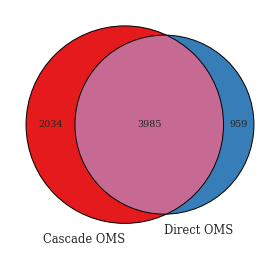

In [7]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

set_cascade = set(psms_cascade.loc[
    psms_cascade['sequence_cascade'].notnull(), 'sequence_cascade'].items())
set_direct = set(psms_cascade.loc[
    psms_cascade['sequence_direct'].notnull(), 'sequence_direct'].items())

v = venn2([set_cascade, set_direct],
          set_labels=['Cascade OMS', 'Direct OMS'],
          set_colors=[next(ax._get_lines.prop_cycler)['color'],
                      next(ax._get_lines.prop_cycler)['color']],
          alpha=1., ax=ax)
c = venn2_circles([set_cascade, set_direct], linewidth=1.0, ax=ax)

# plt.savefig('cascade_venn.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [8]:
psms_match = psms_cascade[psms_cascade['sequence_cascade'].notnull() &
                          psms_cascade['sequence_direct'].notnull() &
                          (psms_cascade['sequence_cascade'] == psms_cascade['sequence_direct'])]
psms_different = psms_cascade[psms_cascade['sequence_cascade'].notnull() &
                              psms_cascade['sequence_direct'].notnull() &
                              (psms_cascade['sequence_cascade'] != psms_cascade['sequence_direct'])]
psms_unique_cascade = (psms_cascade[psms_cascade['sequence_cascade'].notnull()]
                       .drop(psms_match.index, errors='ignore')
                       .drop(psms_different.index, errors='ignore'))
psms_unique_direct = (psms_cascade[psms_cascade['sequence_direct'].notnull()]
                      .drop(psms_match.index, errors='ignore')
                      .drop(psms_different.index, errors='ignore'))

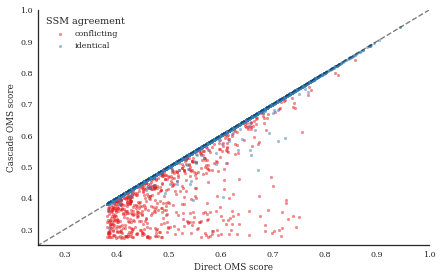

In [9]:
fig, ax = plt.subplots(figsize=(width, height))

ax.scatter(psms_different['search_engine_score[1]_direct'],
           psms_different['search_engine_score[1]_cascade'],
           marker='.', label='conflicting', alpha=0.5)
ax.scatter(psms_match['search_engine_score[1]_direct'],
           psms_match['search_engine_score[1]_cascade'],
           marker='.', label='identical', alpha=0.5)

ax.plot((0, 1), (0, 1), ls='--', c='black', alpha=0.5)

ax.set_xlim(0.25, 1)
ax.set_ylim(0.25, 1)

ax.set_xlabel('Direct OMS score')
ax.set_ylabel('Cascade OMS score')

ax.legend(title='SSM agreement')

sns.despine()

plt.show()
plt.close()

In [10]:
print(f'# identical SSMs: {len(psms_match)}\n'
      f'# conflicting SSMs: {len(psms_different)}\n'
      f'# unique SSMs cascade: {len(psms_unique_cascade)}\n'
      f'# unique SSMs direct: {len(psms_unique_direct)}')

# identical SSMs: 3985
# conflicting SSMs: 690
# unique SSMs cascade: 1344
# unique SSMs direct: 269


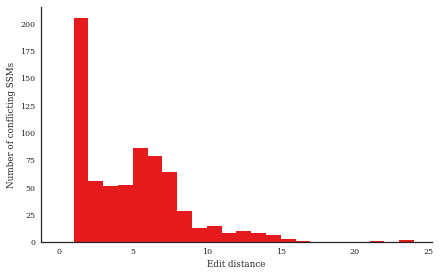

In [11]:
width = 7
height = width / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

# ax.hist(psms_different['edit_dist_norm'], bins=np.arange(0, 1.05, 0.05))
ax.hist(psms_different['edit_dist'], bins=np.arange(0, 25, 1))

ax.set_xlabel('Edit distance')
ax.set_ylabel('Number of conflicting SSMs')

sns.despine()

plt.savefig('cascade_distance.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [12]:
threshold = 3
num_high_sim = len(psms_different[psms_different['edit_dist'] <= threshold])
num_low_sim = len(psms_different[psms_different['edit_dist'] > threshold])
print(f'# conflicting SSMs with high sequence similarity: {num_high_sim}\n'
      f'# conflicting SSMs with low sequence similarity: {num_low_sim}\n'
      f'    (sequence similarity threshold = {threshold} amino acids)')

# conflicting SSMs with high sequence similarity: 312
# conflicting SSMs with low sequence similarity: 378
    (sequence similarity threshold = 3 amino acids)


In [13]:
psms_cascade_true = psms_different[psms_different['sequence_cascade'] == psms_different['sequence_consensus']]
psms_direct_true = psms_different[psms_different['sequence_direct'] == psms_different['sequence_consensus']]
psms_false = (psms_different[psms_different['sequence_consensus'].notnull()]
              .drop(psms_cascade_true.index).drop(psms_direct_true.index))
print(f'# conflicting SSMs cascade OMS corresponding with iPRG2012 consensus: '
      f'{len(psms_cascade_true)}\n'
      f'# conflicting SSMs direct OMS corresponding with iPRG2012 consensus: '
      f'{len(psms_direct_true)}\n'
      f'# conflicting SSMs conflicting with iPRG2012 consensus: '
      f'{len(psms_false)}\n'
      f'# conflicting SSMs not in iPRG2012 consensus: '
      f'{len(psms_different[~psms_different["sequence_consensus"].notnull()])}')

# conflicting SSMs cascade OMS corresponding with iPRG2012 consensus: 429
# conflicting SSMs direct OMS corresponding with iPRG2012 consensus: 52
# conflicting SSMs conflicting with iPRG2012 consensus: 88
# conflicting SSMs not in iPRG2012 consensus: 121


In [14]:
psms_unique_cascade_true = psms_unique_cascade[
    (psms_unique_cascade['sequence_cascade'] == psms_unique_cascade['sequence_consensus']) &
    (psms_unique_cascade['sequence_consensus'].notnull())]
psms_unique_direct_true = psms_unique_direct[
    (psms_unique_direct['sequence_direct'] == psms_unique_direct['sequence_consensus']) &
    (psms_unique_direct['sequence_consensus'].notnull())]
print(f'# unique SSMs cascade OMS corresponding with iPRG2012 consensus: '
      f'{len(psms_unique_cascade_true)} / '
      f'{len(psms_unique_cascade[psms_unique_cascade["sequence_consensus"].notnull()])}\n'
      f'# unique SSMs direct OMS corresponding with iPRG2012 consensus: '
      f'{len(psms_unique_direct_true)} / '
      f'{len(psms_unique_direct[psms_unique_direct["sequence_consensus"].notnull()])}')

# unique SSMs cascade OMS corresponding with iPRG2012 consensus: 604 / 777
# unique SSMs direct OMS corresponding with iPRG2012 consensus: 10 / 150


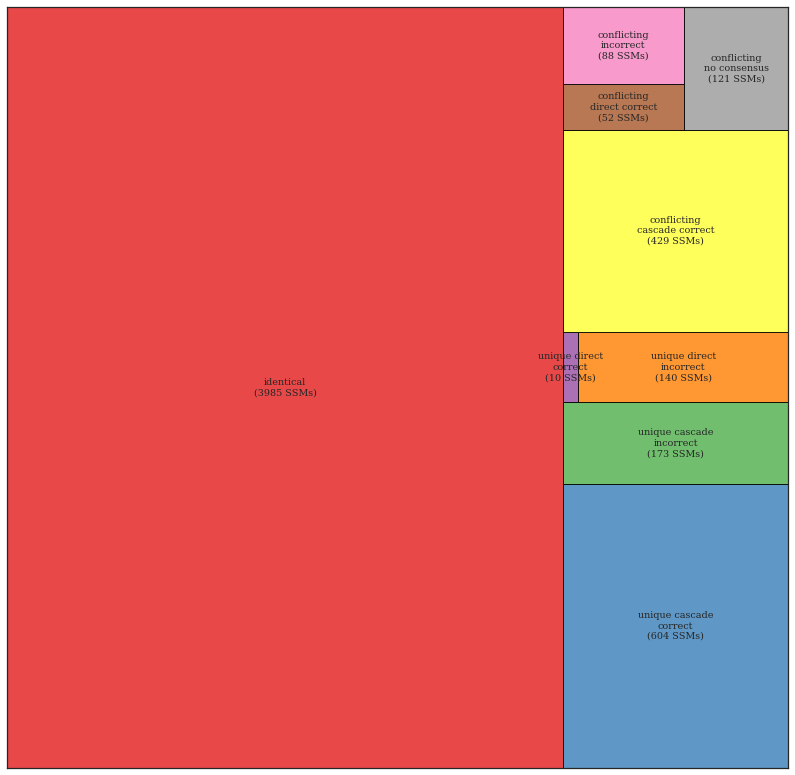

In [15]:
sns.set_palette('Set3')

width = 14
height = width# / 1.618    # golden ratio
fig, ax = plt.subplots(figsize=(width, height))

psms_cascade_false = psms_different[psms_different['sequence_cascade'] != psms_different['sequence_consensus']]
squares = {'identical': len(psms_match),
           'unique cascade\ncorrect': len(psms_unique_cascade_true),
           'unique cascade\nincorrect': len(psms_unique_cascade[psms_unique_cascade['sequence_consensus'].notnull()]) - len(psms_unique_cascade_true),
           'unique direct\ncorrect': len(psms_unique_direct_true),
           'unique direct\nincorrect': len(psms_unique_direct[psms_unique_direct['sequence_consensus'].notnull()]) - len(psms_unique_direct_true),
           'conflicting\ncascade correct': len(psms_cascade_true),
           'conflicting\ndirect correct': len(psms_direct_true),
           'conflicting\nincorrect': len(psms_false),
           'conflicting\nno consensus': len(psms_different[~psms_different['sequence_consensus'].notnull()]),}
squares = dict((f'{key}\n({value} SSMs)', value) for (key, value) in squares.items())

colors = sns.color_palette('Set1', len(squares))

squarify.plot(sizes=squares.values(), color=colors, label=squares.keys(),
              ax=ax, alpha=0.8, linewidth=1, edgecolor='black')

ax.set_xticks([])
ax.set_yticks([])

plt.savefig('cascade_treemap.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()